In [1]:
from dataclasses import dataclass, field
from vi import Agent, Config, Simulation, Vector2, HeadlessSimulation
import pygame as pg
import os
import numpy as np
import random
from multiprocessing import Pool
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
frame_dir = "frames"
os.makedirs(frame_dir, exist_ok=True)
frame_count = 0

def save_frame(screen):
    global frame_count
    pg.image.save(screen, os.path.join(frame_dir, f"frame_{frame_count:05d}.png"))
    frame_count += 1

In [3]:
class RecordingSimulation(Simulation):
    def __init__(self, config):
        super().__init__(config)
        self.frame_count = 0
        os.makedirs("frames", exist_ok=True)

    def after_update(self) -> None:
        # Draw everything to the screen
        self._all.draw(self._screen)

        if self.config.visualise_chunks:
            self.__visualise_chunks()

        # Save current frame as an image
        # pg.image.save(self._screen, f"frames/frame_{self.frame_count:05d}.png")

        # Update the screen with the new image
        pg.display.flip()

        self._clock.tick(self.config.fps_limit)

        current_fps = self._clock.get_fps()
        if current_fps > 0:
            self._metrics.fps._push(current_fps)

            if self.config.print_fps:
                print(f"FPS: {current_fps:.1f}")  # noqa: T201

        # Increment a frame counter (you may need to initialize it somewhere)
        self.frame_count += 1


In [376]:
@dataclass
class PPConfig(Config):
    #desired initial populations
    initial_prey: int = 100
    initial_predators: int = 30

    #parameters of the Lotka-Volterra equations
    alpha = 0.009    # slower prey reproduction
    beta = 0.04     # more effective predators
    delta = 1.0     # predator reproduction chance
    gamma = 0.003    # predator death chance

    shelter_occupied_by = None
    leave_probability = 0.01

config = PPConfig(image_rotation = True, movement_speed = 3.0, radius = 25, duration = 60*60*2, fps_limit = 0)
    

In [248]:
class Prey(Agent):
    def on_spawn(self):
        self.flee_strength = 1.5
        self.join_strength = 1.0
        self.state = "Wander"
        self.wander_direction_cooldown = 50
        self.is_occupying_shelter = False
        return super().on_spawn()
    
    def change_position(self):
        self.there_is_no_escape()

        if random.random() < self.config.alpha:
            pass
            self.reproduce()

        if self.is_occupying_shelter:
            return
        
        intersections = list(self.obstacle_intersections(scale = 1.0))

        if intersections and self.config.shelter_occupied_by == None:
            x, y = self.config.window.as_tuple()
            self.pos = Vector2(x//2 ,y//2)
            self.is_occupying_shelter = True
            self.config.shelter_occupied_by = self
        elif intersections and random.random() < self.config.leave_probability:
            x, y = self.config.window.as_tuple()
            self.pos = Vector2(x//2 ,y//2)
            self.is_occupying_shelter = True
            self.config.shelter_occupied_by.is_occupying_shelter = False
            self.config.shelter_occupied_by = self

        flee_force = Vector2(0, 0)

        neighbors = list(self.in_proximity_accuracy())
        

        if any(isinstance(agent, Predator) for agent, _ in neighbors):
            self.state = "Flee"
        else:
            self.state = "Wander"


        if self.state == "Flee":
            self.wander_direction_cooldown = 0
            predators_nerby = [(agent, dist) for agent, dist in neighbors if isinstance(agent, Predator)]
            for predator, dist in predators_nerby:
                if dist == 0:
                    dist = 0.001
                direction = self.pos - predator.pos
                if dist > 0:
                    direction = direction / dist
                force_magnitude = self.flee_strength / dist
                flee_force += direction * force_magnitude
            
            self.move = flee_force
            if self.move.length() > 0:
                self.move = self.move.normalize() * self.config.movement_speed


        elif self.state == "Wander":
            if self.wander_direction_cooldown == 0:
                self.wander_direction_cooldown = 50
                wander_angle = random.uniform(0, 2 * math.pi)
                wander_force = Vector2(1, 0).rotate_rad(wander_angle)
                self.move = wander_force
                if self.move.length() > 0:
                    self.move = self.move.normalize() * self.config.movement_speed
            else:
                self.wander_direction_cooldown -= 1
            
        self.pos += self.move

In [364]:
class Predator(Agent):
    def on_spawn(self):
        self.random_move_strength = 1.0
        self.predator_speed_boost = 1.0
        self.state = "Wander"
        self.wander_direction_cooldown = 0
        return super().on_spawn()
    
    def change_position(self):
        self.there_is_no_escape()
        if random.random() < self.config.gamma:
            self.kill()
            return
        
        attract_force = Vector2(0, 0)

        neighbors = list(self.in_proximity_accuracy())
        prey_nearby = [(agent, dist) for agent, dist in neighbors if isinstance(agent, Prey) and not(agent.is_occupying_shelter)]
        if prey_nearby:
            self.state = "Hunt"
        else:
            self.state = "Wander"

        if self.state == "Hunt":
            self.wander_direction_cooldown = 0
            the_closest_prey, closest_dist = min(prey_nearby, key=lambda x: x[1])
            if closest_dist == 0:
                    closest_dist = 0.001
            direction = the_closest_prey.pos - self.pos
                
            if closest_dist > 0:
                direction = direction / closest_dist

            force_magnitude = 1.0 / closest_dist
            attract_force += direction * force_magnitude
            if random.random() < self.config.beta and the_closest_prey.is_alive():
                the_closest_prey.kill()
                if random.random() < self.config.delta:
                    self.reproduce()
            
            self.move = attract_force

            if self.move.length() > 0:
                self.move = self.move.normalize() * self.config.movement_speed * self.predator_speed_boost
            
                

        elif self.state == "Wander":
            if self.wander_direction_cooldown == 0:
                self.wander_direction_cooldown = 50
                wander_angle = random.uniform(0, 2 * math.pi)
                wander_force = Vector2(1, 0).rotate_rad(wander_angle)
                self.move = wander_force
                if self.move.length() > 0:
                    self.move = self.move.normalize() * self.config.movement_speed * self.predator_speed_boost
            else:
                self.wander_direction_cooldown -= 1
        
        self.pos += self.move

In [ ]:
x, y = config.window.as_tuple()
(
    RecordingSimulation(
        config
    )
    .spawn_obstacle("images/Shelter.png", x // 2, y // 2)
    .batch_spawn_agents(config.initial_predators, Predator, images=["images/Predator.png"])
    .batch_spawn_agents(config.initial_prey, Prey, images=["images/Prey.png"])
    .run()
)

In [80]:
class HeadlessSimulationRefined(HeadlessSimulation):
   def __init__(self, config):
      super().__init__(config)
      self.frame_count = 0
      self.prey_predator__per_frame = []

   def after_update(self) -> None:
      # Increment a frame counter (you may need to initialize it somewhere)
      
      # if self.frame_count % 10 == 0:
      num_prey = len([agent for agent in self._all if isinstance(agent, Prey)])
      num_predator = len([agent for agent in self._all if isinstance(agent, Predator)])
      self.prey_predator__per_frame.append((num_prey, num_predator))
      if self.frame_count % 50 == 0:
            print(num_prey, num_predator)
      self.frame_count += 1

   def run(self):
        """Run the simulation until it's ended by closing the window or when the `vi.config.Schema.duration` has elapsed."""
        self._running = True

        while self._running:
            self.tick()

        return self.prey_predator__per_frame

In [84]:
def run_simulation(config: Config) -> pl.DataFrame:
    return (
        HeadlessSimulationRefined(config)
        .spawn_obstacle("images/Shelter.png", x // 2, y // 2)
        .batch_spawn_agents(config.initial_predators, Predator, images=["images/Predator.png"])
        .batch_spawn_agents(config.initial_prey, Prey, images=["images/Prey.png"])
        .run()
    )

104 29
123 40
156 55
193 88
205 147
166 232
102 323
38 369
12 353
2 308
1 257
1 221
1 198
1 167
2 145
3 121
2 107
1 94
5 79
5 74
1 69
3 57
2 52
1 48
1 41
3 38
2 35
5 32
5 30
2 28
5 24
7 23
7 25
8 21
7 22
13 16
15 17
21 19
34 15
41 19
55 26
87 28
115 45
147 64
159 109
158 168
92 247
49 287
16 287
2 261
1 229
2 199
2 177
4 154
7 130
3 118
1 107
1 84
1 71
1 62
1 55
2 51
3 45
8 40
11 36
12 38
15 37
15 40
23 40
28 42
44 38
45 44
48 55
69 63
73 84
54 120
32 135
17 140
11 132
6 118
5 109
4 99
3 87
1 76
1 67
1 60
1 52
2 46
2 42
3 37
3 34
5 26
6 25
8 21
14 17
15 18
18 19
19 24
32 26
52 27
60 37
78 47
88 63
85 81
81 105
67 132
38 158
12 167
1 157
2 133
1 122
1 111
1 92
2 73
1 65
1 59
1 52
1 47
1 43
1 36
1 31
1 28
1 28
1 22
1 19
4 16
9 15
12 13
15 12
26 10
44 12
63 19
83 26
104 36
131 57
160 82
153 133
124 195
54 267
13 279
2 253
2 220
1 184
3 155
4 141


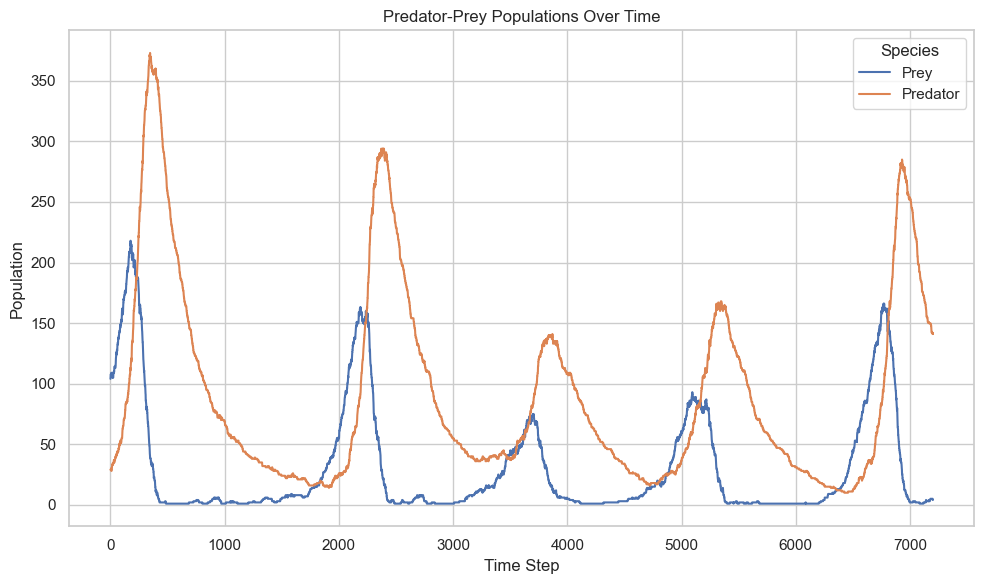

In [377]:
agents_per_frame = run_simulation(config)
df = pd.DataFrame(agents_per_frame, columns=['Prey', 'Predator'])
df['Time'] = range(len(df)) 

df_melted = df.melt(id_vars='Time', value_vars=['Prey', 'Predator'],
                    var_name='Species', value_name='Population')

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='Time', y='Population', hue='Species')
plt.title("Predator-Prey Populations Over Time")
plt.xlabel("Time Step")
plt.ylabel("Population")
plt.legend(title="Species")
plt.tight_layout()
plt.show()